**Introduction**

In this project, I explored algorithms to optimize delivery routes for a courier service, aiming to minimize travel distance while considering delivery time windows. I tested three datasets:

Distinct Towns: Locations split into regions with specific delivery windows.

Sparse Locations: Widely spread-out locations with varying time windows.

Congested Locations: Densely packed urban deliveries.
I compared the performance of Genetic Algorithm (GA) and Ant Colony Optimization (ACO) across these scenarios to identify the most effective approach for different environments.

In [2]:
# Installing necessary libraries
!pip install pandas numpy plotly matplotlib seaborn scikit-learn geopy


   ---------------------------------------- 0.0/125.4 kB ? eta -:--:--
   --- ------------------------------------ 10.2/125.4 kB ? eta -:--:--
   --- ------------------------------------ 10.2/125.4 kB ? eta -:--:--
   --- ------------------------------------ 10.2/125.4 kB ? eta -:--:--
   --- ------------------------------------ 10.2/125.4 kB ? eta -:--:--
   --- ------------------------------------ 10.2/125.4 kB ? eta -:--:--
   --- ------------------------------------ 10.2/125.4 kB ? eta -:--:--
   --- ------------------------------------ 10.2/125.4 kB ? eta -:--:--
   --- ------------------------------------ 10.2/125.4 kB ? eta -:--:--
   --- ------------------------------------ 10.2/125.4 kB ? eta -:--:--
   --- ------------------------------------ 10.2/125.4 kB ? eta -:--:--
   --- ------------------------------------ 10.2/125.4 kB ? eta -:--:--
   --- ------------------------------------ 10.2/125.4 kB ? eta -:--:--
   --- ------------------------------------ 10.2/125.4 kB ? eta -

In [3]:
# importing necessary libraries
import random
import pandas as pd
import numpy as np
import time
from math import radians, sin, cos, sqrt, atan2
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from geopy.distance import geodesic

In [4]:
# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Define color palette for plots
palette = sns.color_palette("coolwarm", as_cmap=True)

I generated synthetic datasets to evaluate the performance of various route optimization algorithms for different delivery scenarios, including distinct towns, sparse locations, and congested urban areas. Each dataset replicated real-world conditions with different geographic spreads and delivery time slots to simulate the challenges of urban, rural, and neighborhood deliveries.

In [5]:
# Function to generate synthetic data for different types of areas
def generate_synthetic_data(regions, num_locations_per_region):
    data = {
        'location_id': [],
        'latitude': [],
        'longitude': [],
        'delivery_start': [],
        'delivery_end': []
    }

    for region, details in regions.items():
        for i in range(num_locations_per_region):
            lat = np.random.uniform(details['lat_range'][0], details['lat_range'][1])
            lon = np.random.uniform(details['lon_range'][0], details['lon_range'][1])

            # Add some noise to the latitude and longitude values
            lat += np.random.uniform(-0.5, 0.5)
            lon += np.random.uniform(-0.5, 0.5)

            data['location_id'].append(len(data['location_id']))
            data['latitude'].append(lat)
            data['longitude'].append(lon)

            # Generate delivery_start and delivery_end based on the region's start_time and end_time ranges
            start_time = random.randint(details['start_time'][0], details['start_time'][1])
            end_time = random.randint(details['end_time'][0], details['end_time'][1])
            data['delivery_start'].append(start_time)
            data['delivery_end'].append(end_time)

    return pd.DataFrame(data)

# Original data with distinct towns
regions_distinct_towns = {
    'Region A': {'lat_range': (-10, -5), 'lon_range': (-10, -5), 'start_time': (480, 540), 'end_time': (720, 780)},
    'Region B': {'lat_range': (-5, 0), 'lon_range': (-5, 0), 'start_time': (600, 660), 'end_time': (840, 900)},
    'Region C': {'lat_range': (0, 5), 'lon_range': (0, 5), 'start_time': (420, 480), 'end_time': (900, 960)},
}

# Sparse locations with wider range
regions_sparse = {
    'Region A': {'lat_range': (-10, 10), 'lon_range': (-10, 10), 'start_time': (480, 540), 'end_time': (720, 780)},
}

# Congested locations with smaller range
regions_congested = {
    'Region A': {'lat_range': (-2, 2), 'lon_range': (-2, 2), 'start_time': (480, 540), 'end_time': (720, 780)},
}

# Number of locations per region
num_locations_per_region = 15

# Generate data
df_distinct_towns = generate_synthetic_data(regions_distinct_towns, num_locations_per_region)
df_sparse = generate_synthetic_data(regions_sparse, 45)  # All locations in one large region
df_congested = generate_synthetic_data(regions_congested, 45)  # All locations in one small region



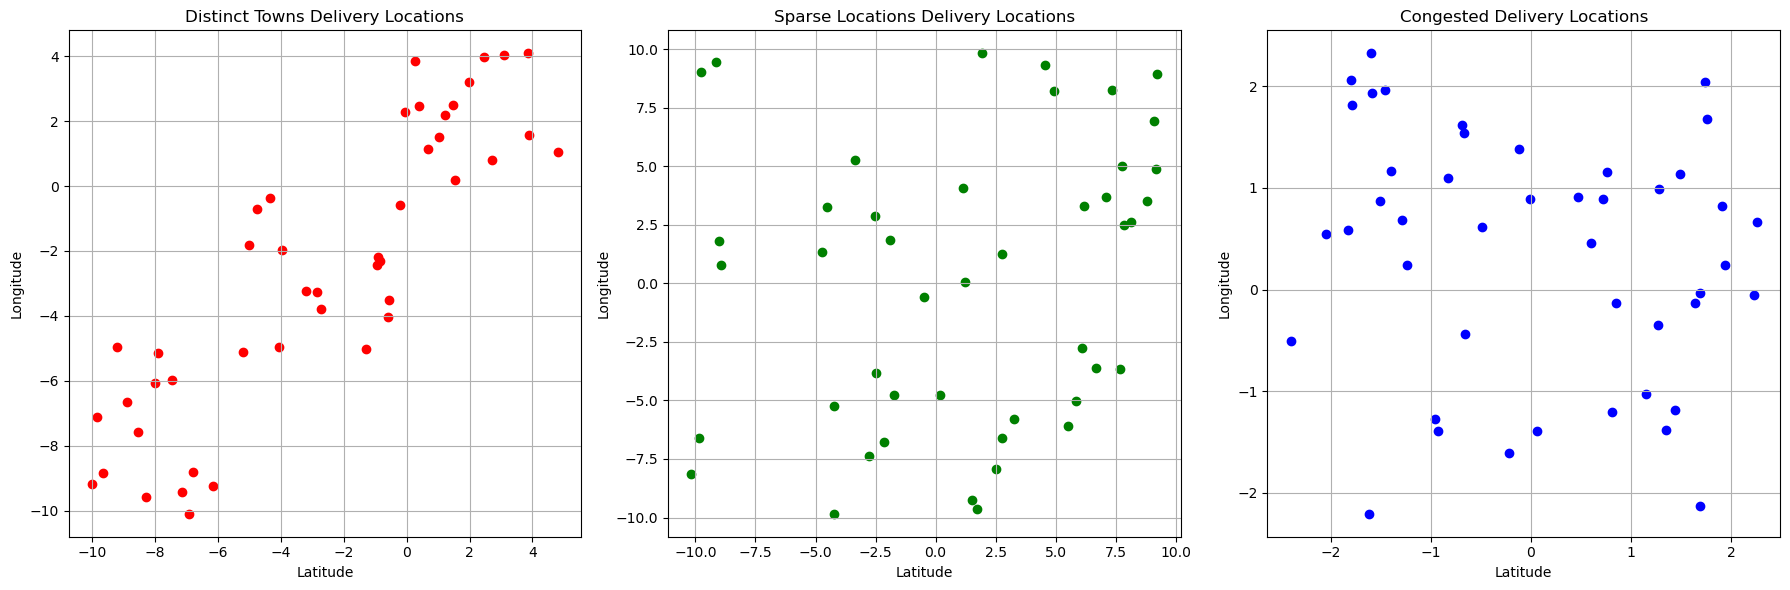

In [6]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot distinct towns
axes[0].scatter(df_distinct_towns['latitude'], df_distinct_towns['longitude'], c='red', marker='o')
axes[0].set_title('Distinct Towns Delivery Locations')
axes[0].set_xlabel('Latitude')
axes[0].set_ylabel('Longitude')
axes[0].grid(True)

# Plot sparse locations
axes[1].scatter(df_sparse['latitude'], df_sparse['longitude'], c='green', marker='o')
axes[1].set_title('Sparse Locations Delivery Locations')
axes[1].set_xlabel('Latitude')
axes[1].set_ylabel('Longitude')
axes[1].grid(True)

# Plot congested locations
axes[2].scatter(df_congested['latitude'], df_congested['longitude'], c='blue', marker='o')
axes[2].set_title('Congested Delivery Locations')
axes[2].set_xlabel('Latitude')
axes[2].set_ylabel('Longitude')
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


The subplot above offers a clear graphical representation of the different delivery locations I generated for this experiment. Visualizing the data this way helped me understand the spatial distribution and clustering of delivery points, which was crucial for identifying the challenges in each scenario.

**Generation of Traffic Data**

For this experiment, I generated synthetic traffic data in the following way:

Random Traffic Data: I created a matrix of random average travel times (in minutes) between each pair of locations, representing typical traffic conditions between delivery points.

Data Frame Creation: I organized the generated traffic data into a DataFrame, with rows and columns corresponding to the locations. Each entry in the DataFrame represents the average travel time between two locations, factoring in traffic effects.

In [7]:
# getting number of locations
num_locations = len(df_distinct_towns)

# Generate random traffic data (average travel times in minutes)
traffic_data = np.random.randint(5, 60, size=(num_locations, num_locations))

# Create a DataFrame for traffic data
df_traffic = pd.DataFrame(traffic_data, columns=range(num_locations), index=range(num_locations))

# showing the traffic dataset
df_traffic.head()

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,55,49,17,8,5,53,44,36,38,32,...,15,55,43,42,38,42,54,38,22,34
1,19,31,55,38,56,42,37,28,19,34,...,27,59,20,35,15,58,20,12,8,44
2,8,29,7,36,7,31,33,36,54,55,...,51,34,47,52,21,30,40,5,12,53
3,39,56,19,51,26,18,30,32,27,18,...,21,43,26,30,48,29,21,17,24,29
4,8,14,7,45,49,22,51,40,51,26,...,8,34,15,34,35,28,59,13,59,7


**Implemetation of the Heuristic Nearest Neighbor (NN) Algorithm for Route Optimization**

In [8]:
# Haversine function to calculate distance between two points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the earth in km
    d_lat = radians(lat2 - lat1)
    d_lon = radians(lon2 - lon1)
    a = sin(d_lat/2) * sin(d_lat/2) + cos(radians(lat1)) * cos(radians(lat2)) * sin(d_lon/2) * sin(d_lon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c  # Distance in km
    return distance

# Function to calculate total distance of a route
def total_distance(route, locations):
    distance = 0
    for i in range(len(route) - 1):
        distance += haversine(locations[route[i]][0], locations[route[i]][1], locations[route[i+1]][0], locations[route[i+1]][1])
    return distance

# Function to calculate adaptability to constraints
def adaptability_to_constraints(route, delivery_windows):
    for i in range(len(route) - 1):
        if not (delivery_windows[route[i]][0] <= delivery_windows[route[i+1]][0] <= delivery_windows[route[i]][1]):
            return False
    return True

# Function to display metrics
def display_metrics(locations, delivery_windows):
    route, exec_time = nearest_neighbor(locations)
    total_dist = total_distance(route, locations)
    adapt_constraints = adaptability_to_constraints(route, delivery_windows)
    num_routes = 1  # Assuming single vehicle for simplicity

    print(f"Total Distance: {total_dist} km")
    print(f"Execution Time: {exec_time} seconds")
    print(f"Adaptability to Constraints: {'Yes' if adapt_constraints else 'No'}")
    print(f"Number of Routes/Trips: {num_routes}")
    return route

# Function to plot the route using Plotly
def plot_route(locations, route):
    # Extract the route coordinates
    lats = [locations[i][0] for i in route]
    lons = [locations[i][1] for i in route]
    ids = [i for i in route]

    # Create a scatter plot for the locations
    fig = go.Figure(go.Scattermapbox(
        lat=lats,
        lon=lons,
        mode='markers+text',
        marker=go.scattermapbox.Marker(size=10, color='red'),
        text=[f'ID: {id_}' for id_ in ids],
        textposition='top right',
    ))

    # Add lines connecting the route
    fig.add_trace(go.Scattermapbox(
        lat=lats,
        lon=lons,
        mode='lines',
        line=dict(width=2, color='blue'),
        text=['Start'] + ['']*(len(lats)-2) + ['End']
    ))

    # Configure the map layout
    fig.update_layout(
        mapbox=dict(
            style="stamen-terrain",
            center=dict(lat=np.mean(lats), lon=np.mean(lons)),
            zoom=10
        ),
        margin=dict(t=0, b=0, l=0, r=0)
    )

    fig.show()

In [9]:
# define the Nearest Neighbor function
# Nearest Neighbor algorithm to create a sample route
def nearest_neighbor(locations):
    start_time = time.time()
    unvisited = list(range(1, len(locations)))
    route = [0]
    while unvisited:
        nearest = min(unvisited, key=lambda x: haversine(locations[route[-1]][0], locations[route[-1]][1], locations[x][0], locations[x][1]))
        route.append(nearest)
        unvisited.remove(nearest)
    route.append(0)
    execution_time = time.time() - start_time
    return route, execution_time

# collecting the delivery windows for each location
delivery_windows  = [[row['delivery_start'], row['delivery_end']] for index, row in df_distinct_towns.iterrows()]

In [10]:
# extracting the latitude and longitude using list comprehension
locations_1 = [[row['latitude'], row['longitude']] for index, row in df_distinct_towns.iterrows()]

# Display the metrics
route = display_metrics(locations_1, delivery_windows)

# Visualize the best route path
plot_route(locations_1, route)

Total Distance: 7746.8008248232145 km
Execution Time: 0.009973526000976562 seconds
Adaptability to Constraints: No
Number of Routes/Trips: 1


In [11]:
# extracting the latitude and longitude using list comprehension
locations_2 = [[row['latitude'], row['longitude']] for index, row in df_sparse.iterrows()]

# Display the metrics
route = display_metrics(locations_2, delivery_windows)

# Visualize the best route path
plot_route(locations_2, route)

Total Distance: 13107.769187180476 km
Execution Time: 0.029956579208374023 seconds
Adaptability to Constraints: No
Number of Routes/Trips: 1


In [12]:
# extracting the latitude and longitude using list comprehension
locations_3 = [[row['latitude'], row['longitude']] for index, row in df_congested.iterrows()]

# Display the metrics
route = display_metrics(locations_3, delivery_windows)

# Visualize the best route path
plot_route(locations_3, route)

Total Distance: 3736.874342535235 km
Execution Time: 0.008981466293334961 seconds
Adaptability to Constraints: No
Number of Routes/Trips: 1


**Implementation of the Ant Colony Optimization (ACO) for Route Optimization**

In [13]:
# Create the graph as an adjacency matrix
def create_graph(locations):
    graph = np.zeros((len(locations), len(locations)))
    for i in range(len(locations)):
        for j in range(len(locations)):
            if i != j:
                graph[i][j] = haversine(locations[i][0], locations[i][1], locations[j][0], locations[j][1])
    return graph


# Function to calculate total distance of a route
def total_distance(route, graph):
    distance = 0
    for i in range(len(route) - 1):
        distance += graph[route[i]][route[i+1]]
    return distance

# Function to calculate adaptability to constraints
def adaptability_to_constraints(route, delivery_windows):
    for i in range(len(route) - 1):
        if not (delivery_windows[route[i]][0] <= delivery_windows[route[i+1]][0] <= delivery_windows[route[i]][1]):
            return False
    return True

# Function to display metrics
def display_metrics(locations, delivery_windows):
    graph = create_graph(locations)
    n_ants = 10
    n_iterations = 100
    alpha = 1.0
    beta = 5.0
    evaporation_rate = 0.5
    pheromone_constant = 100.0
    start_time = time.time()
    route, best_distance = ant_colony_optimization(graph, n_ants, n_iterations, alpha, beta, evaporation_rate, pheromone_constant)
    exec_time = time.time() - start_time
    adapt_constraints = adaptability_to_constraints(route, delivery_windows)
    num_routes = 1  # Assuming single vehicle for simplicity

    print(f"Total Distance: {best_distance:.2f} km")
    print(f"Execution Time: {exec_time:.4f} seconds")
    print(f"Adaptability to Constraints: {'Yes' if adapt_constraints else 'No'}")
    print(f"Number of Routes/Trips: {num_routes}")
    print("Best Route Path (location ids):", route)

    # Visualize the best route path
    plot_route(locations, route)

# Function to plot the route using Plotly
def plot_route(locations, route):
    # Extract the route coordinates
    lats = [locations[i][0] for i in route]
    lons = [locations[i][1] for i in route]
    ids = [i for i in route]

    # Create a scatter plot for the locations
    fig = go.Figure(go.Scattermapbox(
        lat=lats,
        lon=lons,
        mode='markers+text',
        marker=go.scattermapbox.Marker(size=10, color='red'),
        text=[f'ID: {id_}' for id_ in ids],
        textposition='top right',
    ))

    # Add lines connecting the route
    fig.add_trace(go.Scattermapbox(
        lat=lats,
        lon=lons,
        mode='lines',
        line=dict(width=2, color='blue'),
        text=['Start'] + ['']*(len(lats)-2) + ['End']
    ))

    # Configure the map layout
    fig.update_layout(
        mapbox=dict(
            style="stamen-terrain",
            center=dict(lat=np.mean(lats), lon=np.mean(lons)),
            zoom=10
        ),
        margin=dict(t=0, b=0, l=0, r=0)
    )

    fig.show()




In [14]:
# Ant Colony Optimization algorithm
def ant_colony_optimization(graph, n_ants, n_iterations, alpha, beta, evaporation_rate, pheromone_constant):
    n = len(graph)
    pheromones = np.ones((n, n)) / n
    best_route = None
    best_distance = float('inf')

    for iteration in range(n_iterations):
        all_routes = []
        for ant in range(n_ants):
            route = [0]
            visited = set(route)
            while len(visited) < n:
                current_node = route[-1]
                probabilities = []
                for next_node in range(n):
                    if next_node not in visited:
                        trail_strength = pheromones[current_node][next_node] ** alpha
                        visibility = (1 / graph[current_node][next_node]) ** beta
                        probabilities.append(trail_strength * visibility)
                    else:
                        probabilities.append(0)
                probabilities = np.array(probabilities) / np.sum(probabilities)
                next_node = np.random.choice(range(n), p=probabilities)
                route.append(next_node)
                visited.add(next_node)
            route.append(0)
            all_routes.append(route)

        # Update pheromones
        pheromones *= (1 - evaporation_rate)
        for route in all_routes:
            distance = total_distance(route, graph)
            if distance < best_distance:
                best_distance = distance
                best_route = route
            for i in range(len(route) - 1):
                pheromones[route[i]][route[i + 1]] += pheromone_constant / distance

    return best_route, best_distance

In [15]:
# Display the metrics and plot the route
display_metrics(locations_1, delivery_windows)

Total Distance: 9332.45 km
Execution Time: 26.4578 seconds
Adaptability to Constraints: No
Number of Routes/Trips: 1
Best Route Path (location ids): [0, 12, 6, 7, 4, 9, 11, 2, 5, 14, 1, 10, 13, 25, 21, 24, 15, 16, 27, 17, 23, 29, 26, 32, 33, 38, 36, 37, 42, 41, 31, 40, 34, 39, 30, 44, 43, 35, 28, 22, 20, 19, 18, 3, 8, 0]


In [16]:
# Display the metrics and plot the route
display_metrics(locations_2, delivery_windows)

Total Distance: 26202.09 km
Execution Time: 8.2346 seconds
Adaptability to Constraints: No
Number of Routes/Trips: 1
Best Route Path (location ids): [0, 27, 37, 9, 26, 44, 22, 42, 13, 35, 5, 11, 1, 40, 2, 34, 14, 30, 38, 16, 31, 39, 29, 6, 7, 33, 3, 32, 24, 4, 23, 25, 19, 21, 28, 43, 20, 12, 15, 17, 36, 18, 10, 8, 41, 0]


In [17]:
# Display the metrics and plot the route
display_metrics(locations_3, delivery_windows)

Total Distance: 7730.06 km
Execution Time: 5.7536 seconds
Adaptability to Constraints: No
Number of Routes/Trips: 1
Best Route Path (location ids): [0, 18, 8, 15, 40, 35, 30, 6, 34, 31, 38, 36, 22, 17, 29, 14, 23, 7, 44, 19, 33, 25, 11, 39, 41, 32, 21, 37, 9, 26, 4, 10, 27, 1, 43, 13, 12, 2, 16, 3, 24, 28, 42, 20, 5, 0]


**Implementation of the Genetic Algorithm (GA) for Route Optimization**

In [18]:
# Convert the DataFrame to a list of dictionaries for easier access
locations_list_1 = df_distinct_towns.to_dict(orient='records')
locations_list_2 = df_congested.to_dict(orient='records')
locations_list_3 = df_sparse.to_dict(orient='records')

In [19]:
import numpy as np
import random
from geopy.distance import geodesic
import time

# Calculate the total distance of a route
def calculate_total_distance(route, locations):
    total_distance = 0
    for i in range(len(route) - 1):
        loc1 = locations[route[i]]
        loc2 = locations[route[i+1]]
        total_distance += geodesic((loc1['latitude'], loc1['longitude']), (loc2['latitude'], loc2['longitude'])).miles
    # Add distance to return to the starting point
    loc1 = locations[route[-1]]
    loc2 = locations[route[0]]
    total_distance += geodesic((loc1['latitude'], loc1['longitude']), (loc2['latitude'], loc2['longitude'])).miles
    return total_distance

# Generate an initial population of random routes
def generate_initial_population(pop_size, num_locations):
    population = []
    for _ in range(pop_size):
        route = list(range(num_locations))
        random.shuffle(route)
        population.append(route)
    return population

# Evaluate the fitness of the population
def evaluate_fitness(population, locations):
    fitness_scores = []
    for route in population:
        fitness_scores.append(1 / calculate_total_distance(route, locations))  # Inverse of distance
    return fitness_scores

# Select parents using tournament selection
def tournament_selection(population, fitness_scores, k=3):
    selected = random.sample(range(len(population)), k)
    selected_fitness = [fitness_scores[i] for i in selected]
    best_index = selected[np.argmax(selected_fitness)]
    return population[best_index]

# Perform ordered crossover
def ordered_crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))
    child = [None] * size
    child[start:end] = parent1[start:end]
    pointer = 0
    for gene in parent2:
        if gene not in child:
            while child[pointer] is not None:
                pointer += 1
            child[pointer] = gene
    return child

# Perform mutation by swapping two genes
def mutate(route, mutation_rate=0.01):
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(route)), 2)
        route[i], route[j] = route[j], route[i]
    return route

# Genetic Algorithm for route optimization with stopping criterion and timing
def genetic_algorithm(locations, pop_size=100, num_generations=500, mutation_rate=0.01, convergence_generations=50):
    start_time = time.time()  # Start the timer
    num_locations = len(locations)
    population = generate_initial_population(pop_size, num_locations)
    best_fitness = 0
    generations_without_improvement = 0

    for generation in range(num_generations):
        fitness_scores = evaluate_fitness(population, locations)

        if max(fitness_scores) > best_fitness:
            best_fitness = max(fitness_scores)
            generations_without_improvement = 0
        else:
            generations_without_improvement += 1

        if generations_without_improvement >= convergence_generations:
            print(f"Stopping early at generation {generation+1} due to convergence.")
            break

        new_population = []
        for _ in range(pop_size // 2):
            parent1 = tournament_selection(population, fitness_scores)
            parent2 = tournament_selection(population, fitness_scores)
            child1 = ordered_crossover(parent1, parent2)
            child2 = ordered_crossover(parent2, parent1)
            new_population.extend([mutate(child1, mutation_rate), mutate(child2, mutation_rate)])

        population = new_population
        print(f"Generation {generation+1}: Best Fitness = {best_fitness}")

    best_route_index = np.argmax(fitness_scores)
    best_route = population[best_route_index]
    end_time = time.time()  # End the timer
    total_time = end_time - start_time
    print(f"Total time taken: {total_time} seconds")
    return best_route


In [20]:
best_route_1 = genetic_algorithm(locations_list_1)

print("Best Route:", best_route_1)
print("Total Distance:", calculate_total_distance(best_route_1, locations_list_1))

Generation 1: Best Fitness = 5.209285150644283e-05
Generation 2: Best Fitness = 5.606070285909699e-05
Generation 3: Best Fitness = 5.616617964929166e-05
Generation 4: Best Fitness = 5.876805158690294e-05
Generation 5: Best Fitness = 6.349148667859364e-05
Generation 6: Best Fitness = 7.086753763807585e-05
Generation 7: Best Fitness = 7.244363380781616e-05
Generation 8: Best Fitness = 7.244363380781616e-05
Generation 9: Best Fitness = 7.244363380781616e-05
Generation 10: Best Fitness = 7.244363380781616e-05
Generation 11: Best Fitness = 7.244363380781616e-05
Generation 12: Best Fitness = 7.611234583358858e-05
Generation 13: Best Fitness = 8.235349371733344e-05
Generation 14: Best Fitness = 9.073338172045983e-05
Generation 15: Best Fitness = 9.073338172045983e-05
Generation 16: Best Fitness = 9.073338172045983e-05
Generation 17: Best Fitness = 9.073338172045983e-05
Generation 18: Best Fitness = 9.073338172045983e-05
Generation 19: Best Fitness = 9.073338172045983e-05
Generation 20: Best F

In [21]:
# visualizing the best route
plot_route(locations_1, best_route_1)

In [22]:
best_route_2 = genetic_algorithm(locations_list_2)

print("Best Route:", best_route_2)
print("Total Distance:", calculate_total_distance(best_route_2, locations_list_2))

Generation 1: Best Fitness = 0.00017877652650087213
Generation 2: Best Fitness = 0.00017877652650087213
Generation 3: Best Fitness = 0.00017877652650087213
Generation 4: Best Fitness = 0.00017877652650087213
Generation 5: Best Fitness = 0.00017877652650087213
Generation 6: Best Fitness = 0.00018592954689081442
Generation 7: Best Fitness = 0.00019297904880454135
Generation 8: Best Fitness = 0.00019686872340341833
Generation 9: Best Fitness = 0.00019974253613172296
Generation 10: Best Fitness = 0.00019974253613172296
Generation 11: Best Fitness = 0.00020759855053712167
Generation 12: Best Fitness = 0.00020968492302846726
Generation 13: Best Fitness = 0.00021597191023030286
Generation 14: Best Fitness = 0.0002203317762843402
Generation 15: Best Fitness = 0.0002203317762843402
Generation 16: Best Fitness = 0.00022058933295287275
Generation 17: Best Fitness = 0.00022058933295287275
Generation 18: Best Fitness = 0.00023247056824735165
Generation 19: Best Fitness = 0.00023247056824735165
Gene

In [23]:
# visualizing the best route
plot_route(locations_2, best_route_2)

In [24]:
best_route_3 = genetic_algorithm(locations_list_3)

print("Best Route:", best_route_3)
print("Total Distance:", calculate_total_distance(best_route_3, locations_list_3))

Generation 1: Best Fitness = 3.744970455915048e-05
Generation 2: Best Fitness = 3.767642320249205e-05
Generation 3: Best Fitness = 3.800010027439909e-05
Generation 4: Best Fitness = 4.083411129178108e-05
Generation 5: Best Fitness = 4.083411129178108e-05
Generation 6: Best Fitness = 4.111721122370834e-05
Generation 7: Best Fitness = 4.291809771847317e-05
Generation 8: Best Fitness = 4.291809771847317e-05
Generation 9: Best Fitness = 4.450080198092235e-05
Generation 10: Best Fitness = 4.4878044761501905e-05
Generation 11: Best Fitness = 4.4878044761501905e-05
Generation 12: Best Fitness = 4.547654422824835e-05
Generation 13: Best Fitness = 4.793473329323071e-05
Generation 14: Best Fitness = 4.793473329323071e-05
Generation 15: Best Fitness = 5.036797345007211e-05
Generation 16: Best Fitness = 5.036797345007211e-05
Generation 17: Best Fitness = 5.036797345007211e-05
Generation 18: Best Fitness = 5.036797345007211e-05
Generation 19: Best Fitness = 5.036797345007211e-05
Generation 20: Best

In [25]:
# visualizing the best route
plot_route(locations_3, best_route_3)


# Result Summary


## Algorithm Performance Analysis

### 1. Genetic Algorithm (GA)

#### Strengths:
- **Global Search Capability**: GA is effective in exploring a wide solution space, making it less likely to get trapped in local optima compared to some other optimization methods.
- **Adaptability**: The algorithm can easily adapt to changes in the problem constraints, such as varying delivery windows or additional locations, allowing for flexible route planning.
- **Parallelism**: GA can be implemented in parallel, which can significantly reduce computation time, especially for larger datasets with many delivery points.
- **Robustness**: The algorithm performs well across different datasets, demonstrating its versatility in handling various delivery scenarios, including sparse and congested locations.

#### Limitations:
- **Computationally Intensive**: GA can require significant computational resources, particularly for larger datasets, as it involves multiple generations and evaluations of potential solutions.
- **Parameter Sensitivity**: The performance of GA is highly dependent on the choice of parameters (e.g., population size, mutation rate), which may require extensive tuning to achieve optimal results.
- **Convergence Speed**: While GA is good at exploring the solution space, it may converge slowly, especially if the initial population is not diverse enough.

### 2. Ant Colony Optimization (ACO)

#### Strengths:
- **Effective for Dynamic Environments**: ACO is particularly well-suited for dynamic routing problems, as it can adapt to changes in traffic conditions and delivery requirements in real-time.
- **Positive Feedback Mechanism**: The pheromone updating process allows ACO to reinforce successful routes, leading to the emergence of optimal or near-optimal solutions over time.
- **Good for Large Problems**: ACO can efficiently handle large datasets with many delivery points, making it a suitable choice for complex routing scenarios.

#### Limitations:
- **Convergence Issues**: ACO can sometimes converge prematurely to suboptimal solutions, especially if the pheromone evaporation rate is not appropriately set.
- **Computational Overhead**: The algorithm requires multiple iterations to build up pheromone trails, which can lead to longer execution times compared to other methods, particularly in congested environments.
- **Parameter Tuning**: Similar to GA, ACO's performance is sensitive to the choice of parameters (e.g., pheromone importance, evaporation rate), which may require careful tuning to achieve the best results.

### 3. Heuristic Nearest Neighbor (NN) Algorithm

#### Strengths:
- **Simplicity and Ease of Implementation**: The NN algorithm is straightforward to understand and implement, making it accessible for quick route optimization tasks.
- **Fast Execution Time**: Due to its greedy approach, the NN algorithm can quickly generate a route, making it suitable for scenarios where time is a critical factor.
- **Good for Small Datasets**: For smaller sets of delivery points, the NN algorithm can produce reasonably efficient routes without the need for complex computations.

#### Limitations:
- **Local Optima**: The NN algorithm is prone to getting stuck in local optima. It makes decisions based solely on the nearest neighbor, which may not lead to the best overall route.
- **Lack of Global Perspective**: The greedy nature of the algorithm means it does not consider the overall route structure, potentially resulting in longer total distances compared to more sophisticated algorithms.
- **Sensitivity to Starting Point**: The final route can vary significantly based on the initial starting point chosen, leading to inconsistent results across different runs.
- **Inefficiency in Complex Scenarios**: In cases with many delivery points or complex constraints (e.g., time windows, traffic conditions), the NN algorithm may not perform well, as it does not adaptively optimize the route based on these factors.

